<a href="https://colab.research.google.com/github/TerpstraS/GEBM_nadcom23/blob/main/GEBM_nadcom23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from tqdm import tqdm

plt.rc("font", family="serif", size=12.)
plt.rc("savefig", dpi=300, format="png")
plt.rc("legend", loc="best", fontsize="x-small", fancybox=True, framealpha=0.5)
plt.rc("lines", linewidth=1.4, markersize=7, markeredgewidth=1.5)
plt.rc("axes.spines", top=False, right=False)

### Model

In [ ]:
class GEBM:
    def __init__(
        self, tau_a=0, tau_NV=0, nu_NV=0, mu_0=50 * (3600*24*365)**3, rho_0=10, rho_func=None,
        K_eps=0.5
    ):

        # constants
        self.C = 5e8 * (3600*24*365)**2
        self.Q_0 = 341.3 * (3600*24*365)**3
        self.sigma = 5.67e-8 * (3600*24*365)**3
        self.alpha1 = 0.7
        self.alpha2 = 0.289
        self.T_alpha = 274.5
        self.K_alpha = 0.1
        self.eps1 = 0.5
        self.eps2 = 0.41
        self.T_eps = 288
        self.K_eps = K_eps
        self.A0 = 5.35 * (3600*24*365)**3

        # forcing parameters
        self.mu_0 = mu_0
        self.rho_0 = rho_0
        self.rho_func = rho_func # custom function radiative forcing, takes t and rho_0 as parameters

        # parameters
        self.tau_a = tau_a
        self.tau_NV = tau_NV
        self.nu_NV = nu_NV

        # solutions
        self.sol = None
        self.t = None
        self.T = None
        self.x = None
        self.y = None
        self.z = None
        self.alpha = None

        # initial condition
        # this is changed when using equilibriate()
        self.y0 = [255, 10, 10, 5, 0.33]

    def dGEBM(self, t, z, set_equilibrium):
        T, xx, yy, zz, alpha = z

        # calculate albedo if it is instantanuous
        if self.tau_a == 0 or set_equilibrium:
            alpha = self.alpha_0(T)
            dalpha = 0
        else:
            dalpha = (1 / self.tau_a) * (self.alpha_0(T) - alpha)

        # calculate emissivity
        epsilon = self.eps(T)

        # calculate radiative forcing
        # if no custom radiative function or setting equilibrium, use constant forcing
        if self.rho_func is None or set_equilibrium:
            rho = self.rho_0
        else:
            # assume parameters are t and rho_0
            rho = self.rho_func(t, self.rho_0)

        mu = self.mu_0 + self.A0 * np.log(rho / self.rho_0)
#         print(mu)

        if self.tau_NV == 0 or self.nu_NV == 0:
            dx = 0
            dy = 0
            dz = 0
            mu_NV = 0
        else:
            dx = 1 / self.tau_NV * (10 * (yy - xx))
            dy = 1 / self.tau_NV * (xx * (28 - zz) - yy)
            dz = 1 / self.tau_NV * (xx * yy - (8/3) * zz)
            mu_NV = self.nu_NV * np.sin(np.pi * xx / 20)

        # alpha = 0.3

        dT = (1/self.C) * (self.Q_0 * (1 - alpha) - epsilon * self.sigma * T**4 + mu + mu_NV)

        return [dT, dx, dy, dz, dalpha]

    def alpha_0(self, T):
        return self.alpha1 + (self.alpha2-self.alpha1) * (1 + np.tanh(self.K_alpha * (T - self.T_alpha))) / 2

    def eps(self, T):
        return self.eps1 + (self.eps2-self.eps1) * (1 + np.tanh(self.K_eps * (T - self.T_eps))) / 2

    def solve(self, t_end=100, y0=None, t_eval=None):
        t_span = [0, t_end]
        if t_eval is None:
            t_eval = np.linspace(t_span[0], t_span[1], 5001)

        if y0 is None:
            y0 = self.y0

        set_equilibrium = False
        sol = solve_ivp(
            self.dGEBM, t_span, y0, t_eval=t_eval,
            args=(set_equilibrium,),
            rtol=10e-7, atol=10e-8
        )

        self.sol = sol
        self.t = sol.t
        self.T = sol.y[0]
        self.x = sol.y[1]
        self.y = sol.y[2]
        self.z = sol.y[3]
        self.alpha = sol.y[4]

        return sol

    def set_equilibrium(self, t_end=1000, y0=None):
        t_span = [0, t_end]

        if y0 is None:
            y0 = self.y0

        set_equilibrium = True
        sol = solve_ivp(
            self.dGEBM, t_span, y0,
            args=(set_equilibrium,),
            rtol=10e-7, atol=10e-8
        )

        self.y0 = sol.y[:, -1]

        return sol

    def plot_T(self, xlim=None, ylim=None):

        if self.sol is None:
            return

        fig, ax = plt.subplots(tight_layout=True)
        ax.plot(self.t, self.T)
        ax.set_xlabel("time (years)")
        ax.set_ylabel("T (Kelvin)")

        # xlim and ylime should be tuples / lists / array of length 2: e.g. xlim = (10, 100)
        if xlim:
            ax.set_xlim(xlim[0], xlim[1])
        if ylim:
            ax.set_ylim(ylim[0], ylim[1])

    def plot_T_alpha(self, xlim=None, ylim=None):

        if self.sol is None:
            return

        fig, ax = plt.subplots(tight_layout=True)
        ax.plot(self.T, self.alpha)
        ax.set_xlabel("T (Kelvin)")
        ax.set_ylabel("$\\alpha$")

        # xlim and ylime should be tuples / lists / array of length 2: e.g. xlim = (10, 100)
        if xlim:
            ax.set_xlim(xlim[0], xlim[1])
        if ylim:
            ax.set_ylim(ylim[0], ylim[1])

    def plot_mu_rho(self, xlim=None, ylim=None):

        if self.sol is None:
            return

        # calculate rho()
        if self.rho_func is None:
            rhos = np.full(len(self.t), self.rho_0)
        else:
            # assume parameters are t and rho_0
            rhos = np.array([self.rho_func(t, self.rho_0) for t in self.t])

        mus = self.mu_0 + self.A0 / (3600*24*365)**3 * np.log(rhos / self.rho_0)

        fig, ax1 = plt.subplots(tight_layout=True)
        ax1.plot(self.t, rhos, label=r"$\rho$", color="green")

        ax2 = ax1.twinx()
        ax2.plot(self.t, mus, label=r"$\mu$", color="red")
        ax2.tick_params(axis="y", labelcolor="red")

        ax1.set_xlabel("time (years)")
        ax1.set_ylabel(r"$\rho$")
        ax2.set_ylabel(r"$\mu$")
        ax1.legend()

        # xlim and ylime should be tuples / lists / array of length 2: e.g. xlim = (10, 100)
        if xlim:
            ax.set_xlim(xlim[0], xlim[1])
        if ylim:
            ax.set_ylim(ylim[0], ylim[1])


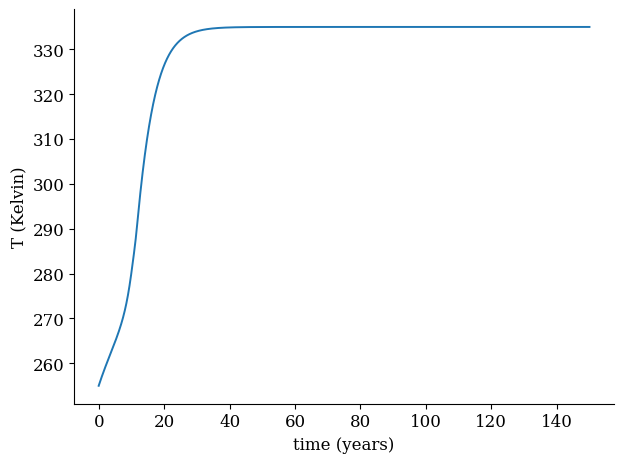

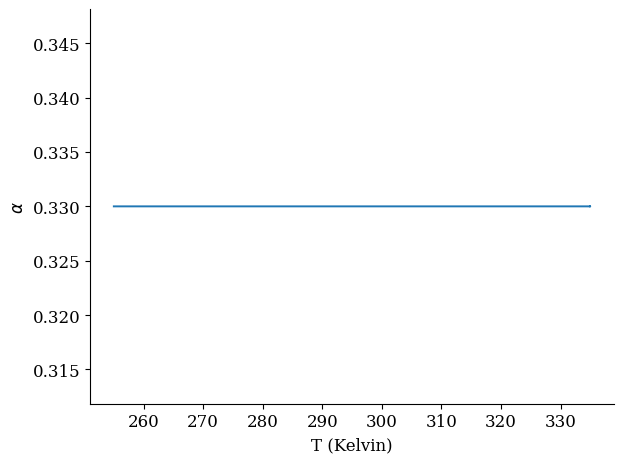

In [ ]:
### usage
# Create model with a given scenario (chaos or not / timescales / forcing parameters)
model = GEBM(tau_a=0, tau_NV=0, nu_NV=0, mu_0=50*(3600*24*365)**3, rho_0=10)

# solve model and plot trajectory
model.solve(t_end=150)
model.plot_T()
model.plot_T_alpha()

100%|██████████| 60/60 [01:27<00:00,  1.45s/it]


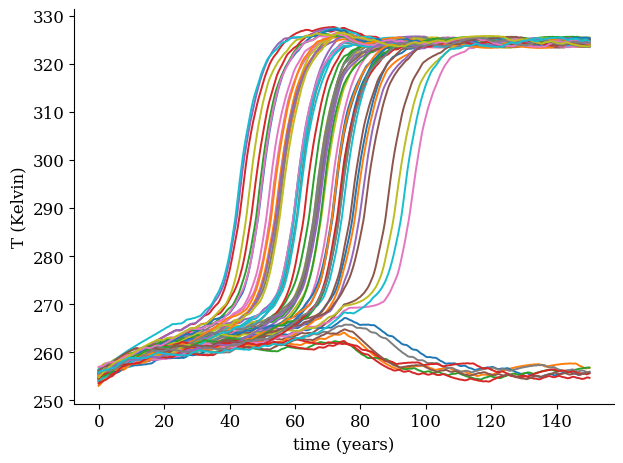

In [ ]:
### usage with custom radiative forcing function (has to take t, rho_0 as parameters)
# and first setting y0 to equilibrium before solving the model
def run_ensemble(
    N, tau_0, tau_NV, nu_NV, t_end, factor, width, do_rho_reduce=False,
    do_plot=True, mu_0=15*(3600*24*365)**3, alpha_0=0.7, T_0=235, seed=123043,
    fname="result"
):

    np.random.seed(seed)
    if do_plot:
        fig, ax = plt.subplots(tight_layout=True)
        ax.set_xlabel("time (years)")
        ax.set_ylabel("T (Kelvin)")

    t_start = 0
    t_points = 1001
    T_sols = np.zeros((N, t_points))
    alpha_sols = np.zeros((N, t_points))

    # create model and obtain starting equilibrium
    model = GEBM(tau_a=tau_a, tau_NV=tau_NV, nu_NV=nu_NV, mu_0=mu_0, rho_0=1)
    y0 = [T_0, np.random.normal(-5, 5), np.random.normal(-5, 5), np.random.normal(-5, 5), alpha_0]
    sol = model.set_equilibrium(y0=y0)

    for i in tqdm(range(N)):

        # redefine rho_func to fit the emission profile we want
        # rho_func = lambda t, rho_0: rho_0 if t < t_start or t > t_start + width else rho_0 * factor
        # rho_func = lambda t, rho_0: rho_0 if t < t_start or t > t_start + width else rho_0 * factor
        def rho_func(t, rho_0):
            if t <= t_start:
                return rho_0
            elif t > t_start and t < t_start + width:
                return rho_0 * factor
            elif t >= t_start + width  and t < t_start + 2 * width and do_rho_reduce:
                return rho_0 / factor
            else:
                return rho_0

        # update model with new rho_func
        model.rho_func = rho_func

        # add small perturbation to lorenz part of initial conditions obtained with
        # equilibrium calculation earlier
        y0 = model.y0
        y0[1] = np.random.normal(-0.1, 0.1)
        y0[2] = np.random.normal(-0.1, 0.1)
        y0[3] = np.random.normal(-0.1, 0.1)
        sol = model.set_equilibrium(y0=y0, t_end=100)

        # solve model
        t_eval = np.linspace(0, t_end, t_points)
        model.solve(t_end=t_end, t_eval=t_eval)

        # store model results for T and alpha
        T_sols[i] = model.T
        alpha_sols[i] = model.alpha

        if do_plot:
            ax.plot(model.t, model.T)

    t_sols = model.t

    # store results
    np.savez(f"{fname}_N.{N}_factor.{factor}_width.{width}_seed.{seed}", T_sols=T_sols, alpha_sols=alpha_sols, t_sols=t_sols)

    return T_sols, alpha_sols, t_sols


# Run example
# Parameters
tau_a =  0 # 5e9 / (3600*24*365)
tau_NV = 6e7 / (3600*24*365)
nu_NV = 5 * (3600*24*365)**3

N = 60
t_end = 150

factor = 4
width = 75

do_rho_reduce = False

T_sols, alpha_sols, t_sols = run_ensemble(N, tau_a, tau_NV, nu_NV, t_end, factor, width, do_rho_reduce=do_rho_reduce, do_plot=True)



In [ ]:
# example download of a single ensemble run
res = np.load(f"results_factor.{factor}_width.{width}.npz")
T_sols = res["T_sols"]
alpha_sols = res["alpha_sols"]
t_sols = res["t_sols"]

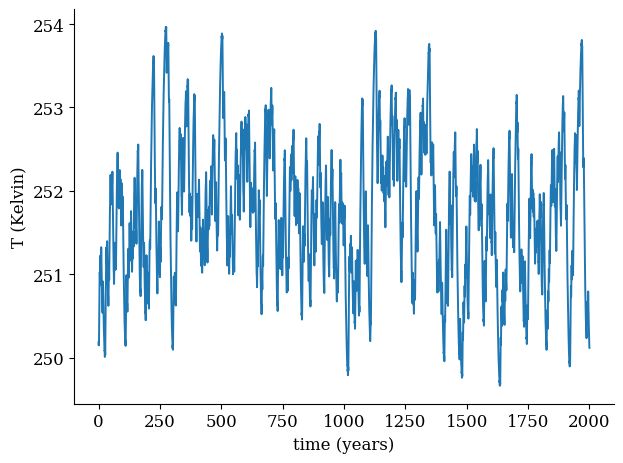

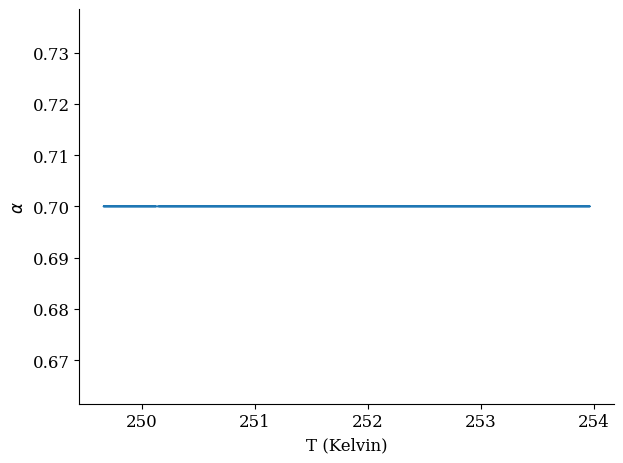

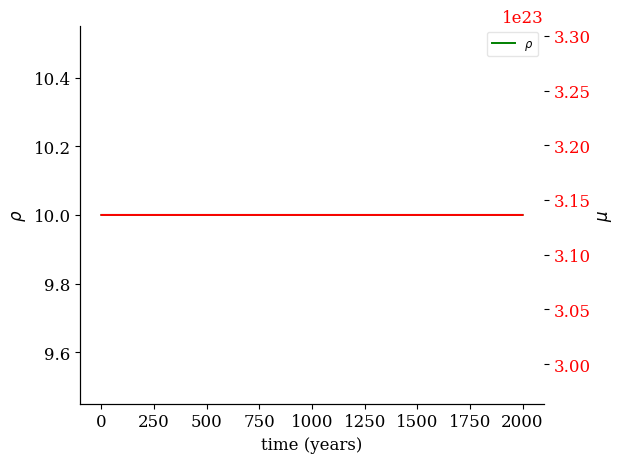

In [ ]:
### usage with custom radiative forcing function (has to take t, rho_0 as parameters)
# and first setting y0 to equilibrium before solving the model

# rho_func = lambda t, rho_0, : rho_0 + 50 * t

tau_a =  0 # 5e9 / (3600*24*365)
tau_NV = 6e7 / (3600*24*365)
nu_NV = 5 * (3600*24*365)**3
model = GEBM(tau_a=tau_a, tau_NV=tau_NV, nu_NV=nu_NV, mu_0=10*(3600*24*365)**3, rho_0=10)

y0 = [200, 10, 10, -10, 0.6]
y0 = [235, np.random.normal(-2, 2), np.random.normal(-2, 2), np.random.normal(-2, 2), 0.7]
model.set_equilibrium(y0=y0)

model.solve(t_end=2000)

model.plot_T()
model.plot_T_alpha()
model.plot_mu_rho()